# Level1. 文書ファイル毎に、Bag-of-Wordsで特徴ベクトルを生成する
必要そうな前処理
1. javascriptやCSSなどのHeader部分を除去（bodyの抜き出し）
2. HTMLタグを除去
3. 文書(document)ごとのリストに分割する

In [1]:
import numpy as np
import pandas as pd
import re
import nltk
import scipy.spatial.distance as distance

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro', 'Yu Gothic', 'Meirio', 'Takao', 'IPAexGothic', 'IPAPGothic', 'VL PGothic', 'Noto Sans CJK JP']

from nltk.tokenize import wordpunct_tokenize, sent_tokenize
# nltk.download('stopwords')

/usr/local/var/pyenv/versions/3.7.4/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/usr/local/var/pyenv/versions/3.7.4/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


## データの読み込み

In [2]:
docs = {}
for idx in range(13):
    with open(f'../dataset/ch{idx:02}.html') as f:
        docs[f'ch{idx:02}'] = f.read()

In [3]:
print(docs['ch00'][:300])

<?xml version="1.0" encoding="ascii" ?>

<script language="javascript" type="text/javascript">

function astext(node)
{
    return node.innerHTML.replace(/(<([^>]+)>)/ig,"")
                         .replace(/&gt;/ig, ">")
                         .replace(/&lt;/ig, "<")
                         .re


### 前処理をかける

In [4]:
def preprocessing(raw_text):
    bodytext = re.findall(r'<body>.+</body>', raw_text.replace('\n', ' '))[0]
    body_text_removed_HTMLTag = re.sub('<[^>]+>', '', bodytext)
    return body_text_removed_HTMLTag

In [5]:
for k, d in docs.items():
    docs[k] = preprocessing(d)

In [6]:
print(docs['ch00'][:300])

  Preface                                    This is a book about Natural Language Processing. By &quot;natural language&quot; we mean a language that is used for everyday communication by humans; languages like English, Hindi or Portuguese. In contrast to artificial languages such as programming la


## Bug-of-Wordsで特徴ベクトルを作成する

In [7]:
# 文書集合からターム素性集合（コードブック）を作る
def collect_words_eng(docs):
    '''英文書集合から単語コードブック作成。
    シンプルに文書集合を予め決めうちした方式で処理する。
    必要に応じて指定できるようにしていた方が使い易いかも。

    :param docs(list): 1文書1文字列で保存。複数文書をリストとして並べたもの。
    :return (list): 文分割、単語分割、基本形、ストップワード除去した、ユニークな単語一覧。
    '''
    codebook = []
    stopwords = nltk.corpus.stopwords.words('english')
    stopwords.append('.')   # ピリオドを追加。
    stopwords.append(',')   # カンマを追加。
    stopwords.append('')    # 空文字を追加。
    # TODO: 記号だけのものを削除する処理が必要そう
    wnl = nltk.stem.wordnet.WordNetLemmatizer()
    for doc in docs:
        for sent in sent_tokenize(doc):
            for word in wordpunct_tokenize(sent):
                this_word = wnl.lemmatize(word.lower())
                if this_word not in codebook and this_word not in stopwords:
                    codebook.append(this_word)
    return codebook

In [8]:
codebook = collect_words_eng(docs.values())

In [9]:
# コードブックを素性とする文書ベクトルを作る (直接ベクトル生成)
def make_vectors_eng(docs, codebook):
    '''コードブックを素性とする文書ベクトルを作る（直接ベクトル生成）

    :param docs(list): 1文書1文字列で保存。複数文書をリストとして並べたもの。
    :param codebook(list): ユニークな単語一覧。
    :return (list): コードブックを元に、出現回数を特徴量とするベクトルを返す。
    '''
    vectors = []
    wnl = nltk.stem.wordnet.WordNetLemmatizer()
    for doc in docs:
        this_vector = []
        fdist = nltk.FreqDist()
        for sent in sent_tokenize(doc):
            for word in wordpunct_tokenize(sent):
                this_word = wnl.lemmatize(word.lower())
                fdist[this_word] += 1
        for word in codebook:
            this_vector.append(fdist[word])
        vectors.append(this_vector)
    return vectors

In [10]:
vectors = make_vectors_eng(docs.values(), codebook)

In [11]:
np.array(vectors)

array([[ 1, 42, 21, ...,  0,  0,  0],
       [ 0, 44, 11, ...,  0,  0,  0],
       [ 0, 10,  4, ...,  0,  0,  0],
       ...,
       [ 0,  3, 28, ...,  0,  0,  0],
       [ 0,  1,  3, ...,  0,  0,  0],
       [ 1,  5, 14, ...,  1,  1,  1]])

## 作成した特徴ベクトルの類似度を計算する

In [12]:
def cosine_similarity(vectors):
    vectors = np.array(vectors)
    distances = []
    for i in range(len(vectors)):
        temp = []
        for j in range(len(vectors)):
            temp.append(1 - distance.cosine(vectors[i], vectors[j]))
        distances.append(temp)
    return distances

In [13]:
cos_similarity_matrix = np.array(cosine_similarity(vectors))

In [14]:
print(cos_similarity_matrix)

[[1.         0.41096018 0.32572154 0.37307515 0.41432588 0.37788894
  0.41175418 0.45486605 0.47101329 0.31412722 0.34754576 0.42305562
  0.75351216]
 [0.41096018 1.         0.89881764 0.95918683 0.95186228 0.91432704
  0.79471295 0.76542878 0.76283245 0.68038865 0.77147264 0.84982529
  0.41589973]
 [0.32572154 0.89881764 1.         0.93557596 0.86924666 0.90720589
  0.65443203 0.64404071 0.64047224 0.6311044  0.60827352 0.6956173
  0.31476542]
 [0.37307515 0.95918683 0.93557596 1.         0.93941615 0.91874043
  0.75514858 0.75520551 0.74716619 0.70535771 0.73466085 0.82278047
  0.38027122]
 [0.41432588 0.95186228 0.86924666 0.93941615 1.         0.90196483
  0.82118901 0.79743713 0.7945122  0.74817703 0.8019962  0.8409703
  0.40732625]
 [0.37788894 0.91432704 0.90720589 0.91874043 0.90196483 1.
  0.76311029 0.79180083 0.73509403 0.67859625 0.71838142 0.7826605
  0.38393269]
 [0.41175418 0.79471295 0.65443203 0.75514858 0.82118901 0.76311029
  1.         0.79117665 0.77917269 0.698237

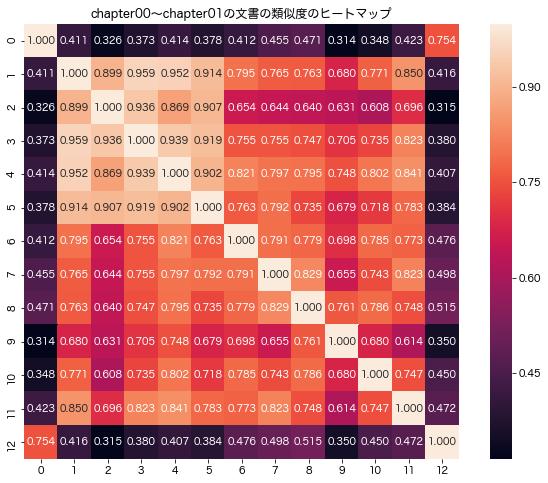

In [15]:
fig, ax = plt.subplots(figsize=(11,8))
sns.heatmap(cos_similarity_matrix, annot=True, fmt='.3f', square=True, ax=ax)
ax.set_ylim(13, 0)
plt.title("chapter00〜chapter01の文書の類似度のヒートマップ")
plt.show()

chapter2とchapter３の類似度がもっとも高い...  
類似度が高くなった理由はなんだろう...

## chapter2とchapter3の類似度が高い理由を考える

- 類似度を算出した2つの文書でユニークな単語を抜き出す
- ユニークなもので2つの文書間で一致しているものの割合を算出する

In [16]:
ch_cwe = {}
for idx in range(13):
    ch_cwe[f'ch{idx:02}'] = collect_words_eng([docs[f'ch{idx:02}']])

In [17]:
def percentage_same_word(l1: list, l2: list):
    count = 0
    for d in l1:
        if d in l2:
            count += 1
    # 少ない方のリストの内、どれくらい一致したかを返す
    result = count/len(l2) if l1 > l2 else count/len(l1)
    return result

In [18]:
result = []
for i in range(13):
    temp = []
    for j in range(13):
        temp.append(percentage_same_word(ch_cwe[f'ch{i:02}'], ch_cwe[f'ch{j:02}']))
    result.append(temp)

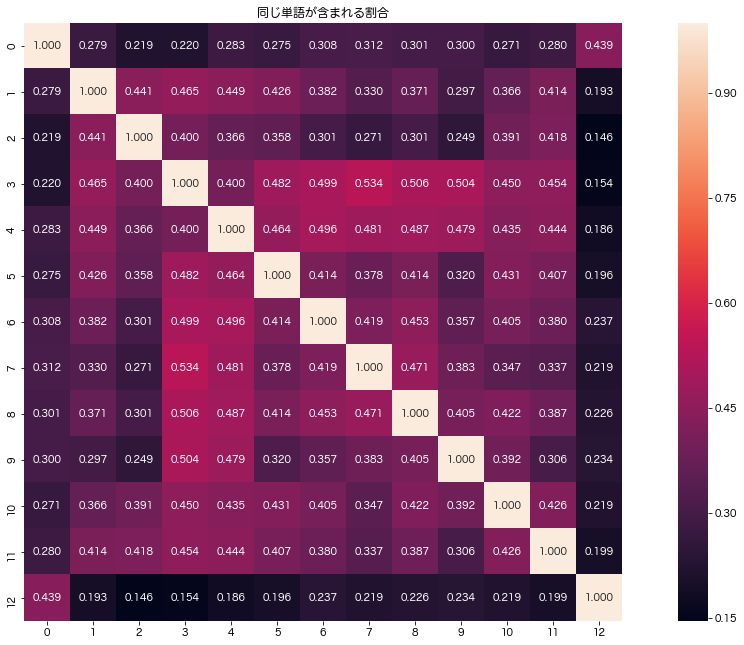

In [19]:
fig, ax = plt.subplots(figsize=(20,11))
sns.heatmap(np.array(result), annot=True, fmt='.3f', square=True, ax=ax)
ax.set_ylim(13, 0)
plt.title("同じ単語が含まれる割合")
plt.show()

でも、これだと文書の大きさを考慮できていない（なんども出てきていても考慮されない）

別のやり方だと、BoWで作成したベクトルは単語の出現頻度となっているので、ベクトルの類似度が高いということは、その文書中に出現する単語の傾向が似ているという事になるので、単語の出現数を見ればいいのではないか？

In [20]:
df = pd.DataFrame(columns=codebook, data=np.array(vectors)).T
df

,0,1,2,3,4,5,6,7,8,9,10,11,12
preface,1,0,0,0,0,0,0,0,0,0,0,0,1
book,42,44,10,7,10,7,3,0,3,3,3,1,5
natural,21,11,4,3,9,5,4,6,8,5,28,3,14
language,62,57,50,27,29,23,19,6,22,5,42,71,54
processing,26,12,13,31,12,12,8,2,4,3,8,6,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...
fluency,0,0,0,0,0,0,0,0,0,0,0,0,1
unfortunate,0,0,0,0,0,0,0,0,0,0,0,0,1
concluded,0,0,0,0,0,0,0,0,0,0,0,0,1
pathway,0,0,0,0,0,0,0,0,0,0,0,0,1


In [21]:
columns = []
data = []
for idx, d in df.iterrows():
    if sum(d.values) > 400:
        columns.append(idx)
        data.append(d)

In [22]:
vector2 = np.array(data).T

In [23]:
df2 = pd.DataFrame(data=data)
df2.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
language,62,57,50,27,29,23,19,6,22,5,42,71,54
&,16,413,427,707,531,438,369,406,223,186,498,776,19
quot,12,113,87,298,184,150,168,314,154,111,66,205,14
;,57,532,486,902,616,535,448,390,404,451,819,735,35
&#,23,68,48,135,62,58,39,22,54,45,228,24,10


In [24]:
df2['sum'] = df2.apply(lambda x: sum(x), axis=1)

In [25]:
df2 = df2.sort_values('sum', ascending=False).drop('sum', axis=1)
df2.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
gt,3,593,685,989,816,682,399,281,258,411,813,617,0
;,57,532,486,902,616,535,448,390,404,451,819,735,35
',18,461,1021,1107,588,627,187,150,230,499,235,209,8
&,16,413,427,707,531,438,369,406,223,186,498,776,19
;&,2,444,518,697,567,523,336,241,176,174,496,357,0


In [26]:
df3 = df２.apply(lambda x: x/sum(x))
df3.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
gt,0.004444,0.111445,0.094875,0.109487,0.108873,0.097082,0.081263,0.064390,0.065119,0.077708,0.116593,0.114492,0.000000
;,0.084444,0.099981,0.067313,0.099856,0.082188,0.076157,0.091242,0.089368,0.101969,0.085271,0.117453,0.136389,0.100287
',0.026667,0.086638,0.141413,0.122551,0.078452,0.089253,0.038086,0.034372,0.058051,0.094347,0.033701,0.038783,0.022923
&,0.023704,0.077617,0.059141,0.078269,0.070847,0.062349,0.075153,0.093034,0.056285,0.035167,0.071418,0.143997,0.054441
;&,0.002963,0.083443,0.071745,0.077162,0.075650,0.074448,0.068432,0.055225,0.044422,0.032898,0.071132,0.066246,0.000000


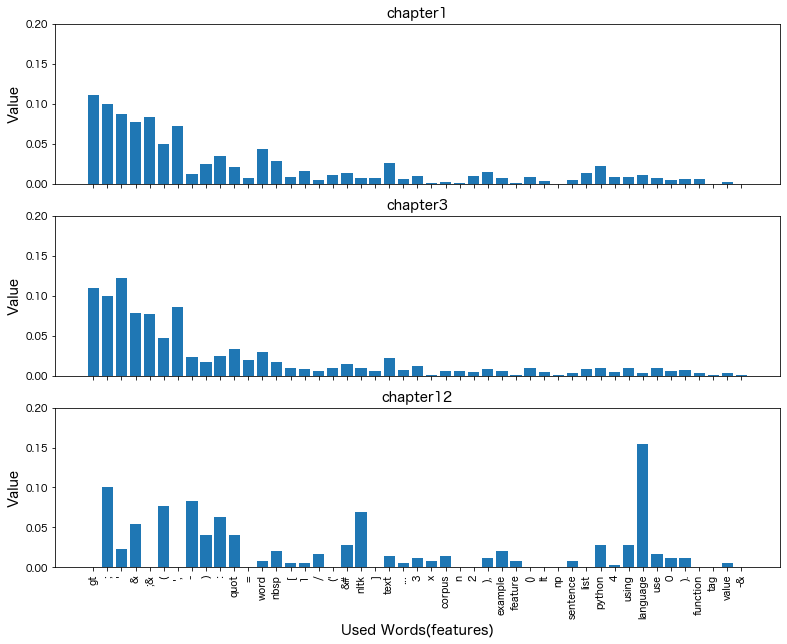

In [27]:
fig, axs = plt.subplots(3, 1, figsize=(13,10))
axs[0].bar(df3.index, df3[1])
axs[0].set_title('chapter1', fontsize=14)
axs[1].bar(df3.index, df3[3])
axs[1].set_title('chapter3', fontsize=14)
axs[2].bar(df3.index, df3[12])
axs[2].set_title('chapter12', fontsize=14)

plt.xticks(rotation=90)

for ax in axs.flat:
    ax.set_ylim([0, 0.2])
    ax.set_xlabel('Used Words(features)', fontsize=14)
    ax.set_ylabel('Value', fontsize=14)

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

やはり類似度が高いchapter1とchapter3は似たような単語の出現分布が似ている。